In [47]:
# ===== generate_new_images.py (in-notebook cell) =====
import torch, math, re
from pathlib import Path
from torchvision.utils import save_image, make_grid

# NEW: for writing a title on the grid
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# --- 1) CONFIG ----
RUN_DIR   = Path("wgangp_128")  # <- set to your run dir
CKPT_DIR  = RUN_DIR / "ckpt"
OUT_DIR   = RUN_DIR / "samples_inference"
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2) ARCH: must match what you trained ---
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

def weights_init_dcgan(m):
    name = m.__class__.__name__
    if "Conv" in name and hasattr(m, "weight"):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None: nn.init.zeros_(m.bias)
    elif "BatchNorm" in name:
        if getattr(m, "weight", None) is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)

class ResUpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.skip  = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        out = self.conv1(x); out = self.bn1(out); out = F.relu(out, True)
        out = self.conv2(out); out = self.bn2(out)
        skip = self.skip(x)
        return F.relu(out + skip, True)

class SelfAttention(nn.Module):
    def __init__(self, ch, sn=False):
        super().__init__()
        conv = (lambda *a, **k: SN(nn.Conv2d(*a, **k))) if sn else nn.Conv2d
        self.f = conv(ch, ch//8, 1, bias=False)
        self.g = conv(ch, ch//8, 1, bias=False)
        self.h = conv(ch, ch//2, 1, bias=False)
        self.v = conv(ch//2, ch, 1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        b,c,H,W = x.size()
        f = self.f(x).view(b,-1,H*W)
        g = self.g(x).view(b,-1,H*W)
        beta = torch.softmax(torch.bmm(f.transpose(1,2), g), dim=-1)
        h_ = self.h(x).view(b,-1,H*W)
        o = torch.bmm(h_, beta).view(b,-1,H,W)
        o = self.v(o)
        return self.gamma * o + x

class Generator128_Res(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.fc = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16), nn.ReLU(True),
            nn.Conv2d(ngf*16, ngf*16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf*16), nn.ReLU(True),
        )
        self.b1 = ResUpBlock(ngf*16, ngf*8)   # 4->8
        self.b2 = ResUpBlock(ngf*8,  ngf*4)   # 8->16
        self.b3 = ResUpBlock(ngf*4,  ngf*2)   # 16->32
        self.attn32 = SelfAttention(ngf*2, sn=False)  # comment out if you trained without
        self.b4 = ResUpBlock(ngf*2,  ngf)     # 32->64
        self.to_rgb = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 64->128
            nn.Tanh(),
        )
    def forward(self, z):
        x = self.fc(z)
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.attn32(x)   # comment out if not used in training
        x = self.b4(x)
        return self.to_rgb(x)

# --- 3) HYPERPARAMS (must match training) ---
nc  = 1          # 1 for grayscale, 3 for RGB
nz  = 128
ngf = 160

# --- 4) Load latest checkpoint ---
ckpts = sorted(CKPT_DIR.glob("epoch_*_G.pt"))
assert ckpts, f"No checkpoints found in {CKPT_DIR}"
last = ckpts[-1]
state = torch.load(last, map_location=device)
print(f"Loading G from: {last.name} (epoch {state.get('epoch','?')})")

G = Generator128_Res(nz, ngf, nc).to(device)
G.load_state_dict(state["G"])
G.eval()

# --- 5) Sampling utilities ---
def to_display(x, mode="linear", eps=1e-6):
    if mode == "linear":
        y = (x + 1) / 2
    elif mode == "stretch":
        B = x.size(0); flat = x.view(B, -1)
        mn = flat.min(dim=1, keepdim=True).values
        mx = flat.max(dim=1, keepdim=True).values
        y = ((flat - mn) / (mx - mn + eps)).view_as(x)
    else:
        y = (x + 1) / 2
    return y.clamp(0,1)

def _tensor_to_pil(img_t: torch.Tensor, is_gray: bool) -> Image.Image:
    """img_t: CxHxW in [0,1]"""
    c, h, w = img_t.shape
    arr = (img_t.clamp(0,1).mul(255).byte().cpu().numpy())
    if is_gray:
        arr = arr[0]  # HxW
        pil = Image.fromarray(arr, mode="L")
    else:
        arr = np.transpose(arr, (1,2,0))  # HxWxC
        pil = Image.fromarray(arr, mode="RGB")
    return pil

def _draw_title_above(img: Image.Image, title: str, pad: int = 12) -> Image.Image:
    """Create a new image with extra top margin and draw centered title."""
    if not title:
        return img
    W, H = img.size
    # choose a font size ~5% of width, floor to >=12
    font_size =max(5, int(W * 0.025))
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()
    draw = ImageDraw.Draw(img)
    # compute text bbox on a dummy line to get exact height
    tw, th = draw.textlength(title, font=font), font_size
    # make a new canvas with top band
    top_band = th + 2*pad
    canvas = Image.new(img.mode, (W, H + top_band), color=0 if img.mode=="L" else (0,0,0))
    canvas.paste(img, (0, top_band))
    draw = ImageDraw.Draw(canvas)
    tx = (W - int(tw)) // 2
    ty = pad
    # draw shadow for readability then text (works for L and RGB)
    if canvas.mode == "L":
        shadow = 255
        textcol = 255
    else:
        shadow = (255,255,255)
        textcol = (255,255,255)
    draw.text((tx+1, ty+1), title, font=font, fill=shadow)
    draw.text((tx, ty), title, font=font, fill=textcol)
    return canvas

@torch.no_grad()
def sample_and_save(
    num_images=128,
    batch_size=64,
    grid_nrow=16,
    seed=42,
    prefix="gen",
    # NEW:
    grid_out_path=None,           # Path or str; if None -> OUT_DIR / f"{prefix}_grid.png"
    title=None,                   # Title text to draw above grid (e.g., "AIA 193Å")
):
    """
    Saves individual images to OUT_DIR and one titled grid to grid_out_path.
    """
    gdev = next(G.parameters()).device
    rng = torch.Generator(device=gdev)
    rng.manual_seed(seed)
    imgs = []

    n_batches = math.ceil(num_images / batch_size)
    for bi in range(n_batches):
        cur_bs = batch_size if (bi < n_batches-1 or num_images % batch_size == 0) else (num_images % batch_size)
        z = torch.randn(cur_bs, nz, 1, 1, device=gdev, generator=rng)
        x = G(z)
        v = to_display(x, mode="stretch")
        imgs.append(v.cpu())

        # save individuals
        for i in range(cur_bs):
            save_image(v[i], OUT_DIR / f"{prefix}_{bi*batch_size+i:05d}.png")

    # build grid
    grid_count = min(128, num_images)
    grid_tensor = torch.cat(imgs, dim=0)[:grid_count]
    grid = make_grid(grid_tensor, nrow=grid_nrow)

    # decide output path for the grid
    if grid_out_path is None:
        grid_out_path = OUT_DIR / f"{prefix}_grid.png"
    else:
        grid_out_path = Path(grid_out_path)
        grid_out_path.parent.mkdir(parents=True, exist_ok=True)

    # convert to PIL (+ title) then save
    is_gray = (nc == 1)
    pil = _tensor_to_pil(grid, is_gray=is_gray)
    pil = _draw_title_above(pil, title=title or "")
    pil.save(grid_out_path)

    print(f"Saved {num_images} images to {OUT_DIR}")
    print(f"Saved titled grid to: {grid_out_path}")

# --- 6) GO: generate images ---
# Example usage:
#   - Individuals go to RUN_DIR/samples_inference
#   - Grid goes to a custom folder with a visible title
sample_and_save(
    num_images=12000,
    batch_size=64,
    grid_nrow=16,
    seed=123,
    prefix="wgan_res_HMI_continuum",
    grid_out_path=Path("wgangp_128") / "HMI_continuum_grid.png",  # <- your custom grid path
    title="HMI_continuum"                                   # <- wavelength name on top
)


/tmp/ipykernel_134283/2945560977.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(last, map_location=device)


Loading G from: epoch_0500_G.pt (epoch 500)
Saved 12000 images to wgangp_128/samples_inference
Saved titled grid to: wgangp_128/HMI_continuum_grid.png


In [48]:
# import os
# import shutil

# # === CONFIGURE THIS ===
# folder_path = r"wgangp_128/samples_inference"  # 👈 change this to your target folder

# # === DELETE ALL CONTENTS ===
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.remove(file_path)      # delete file or symlink
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)  # delete folder recursively
#     except Exception as e:
#         print(f"❌ Failed to delete {file_path}. Reason: {e}")

# print(f"✅ All contents of '{folder_path}' have been deleted.")


In [49]:
import shutil
from pathlib import Path
from IPython.display import FileLink

# === CONFIGURE THESE ===
# Path to your file or folder
source_path = Path(r"wgangp_128/samples_inference")  # <-- change this
# Name for the zip file (without .zip extension)
zip_name = "HMI_continuum_samples"  # <-- change this

# === DO NOT CHANGE BELOW ===
# Create ZIP archive in the same directory as the source
zip_path = source_path.parent / zip_name
shutil.make_archive(str(zip_path), 'zip', root_dir=str(source_path))

# Display path to confirm
print(f"Zipped file created at: {zip_path}.zip")

# If you’re in a notebook environment, make a download link:
try:
    display(FileLink(f"{zip_path}.zip"))
except:
    print("Download link only works in notebook environments (like Jupyter or Colab).")


Zipped file created at: wgangp_128/HMI_continuum_samples.zip


/teamspace/studios/this_studio/wgangp_128/HMI_continuum_samples.zip

In [57]:
# ==== real vs generated side-by-side preview (from given folder) ====
import os, random, torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def _to_display(x, mode="stretch", eps=1e-6):
    """convert [-1,1] → [0,1]"""
    if mode == "linear":
        y = (x + 1) / 2
    elif mode == "stretch":
        B = x.size(0)
        flat = x.view(B, -1)
        mn = flat.min(dim=1, keepdim=True).values
        mx = flat.max(dim=1, keepdim=True).values
        y = ((flat - mn) / (mx - mn + eps)).view_as(x)
    else:
        y = (x + 1) / 2
    return y.clamp(0, 1)


@torch.no_grad()
def plot_real_vs_fake_from_path(
    real_dir,
    n_rows=8,
    use_ema=True,
    vis_mode="stretch",
    seed=4,
    save_path=None,
):
    """
    Compare generated images with real ones from a directory.
    - real_dir: path to folder of real images (.png/.jpg)
    - use_ema: use EMA generator if available
    - vis_mode: "stretch" or "linear"
    - save_path: if given, saves the figure
    """
    # 🌟 Extract wavelength name from folder name
    wavelength = os.path.basename(os.path.normpath(real_dir))
    print(f"\n🔭 Wavelength: {wavelength}")

    # 1) get real images from folder
    image_files = [f for f in os.listdir(real_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    assert len(image_files) > 0, f"No images found in {real_dir}"
    random.seed(seed)
    chosen = random.sample(image_files, min(n_rows, len(image_files)))

    # load and preprocess
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    real_imgs = []
    for f in chosen:
        img = Image.open(os.path.join(real_dir, f)).convert("RGB" if nc == 3 else "L")
        real_imgs.append(transform(img))
    real = torch.stack(real_imgs).to(device)

    # 2) generator (EMA if available)
    model = (ema.tgt if (use_ema and 'ema' in globals()) else G).eval()

    # 3) generate fakes
    gdev = next(model.parameters()).device
    torch.manual_seed(seed)
    z = torch.randn(real.size(0), nz, 1, 1, device=gdev)
    fake = model(z)

    # 4) normalize
    real_v = _to_display(real, vis_mode).cpu()
    fake_v = _to_display(fake, vis_mode).cpu()

    # 5) plot side by side
    fig, axes = plt.subplots(n_rows, 2, figsize=(6, 3 * n_rows), constrained_layout=True)
    if n_rows == 1:
        axes = axes.reshape(1, 2)
    for i in range(real_v.size(0)):
        r = real_v[i].permute(1, 2, 0).squeeze()
        f = fake_v[i].permute(1, 2, 0).squeeze()
        ax = axes[i, 0]
        ax.imshow(r, cmap="gray" if nc == 1 else None)
        ax.set_title("Real", fontsize=11); ax.axis("off")
        ax = axes[i, 1]
        ax.imshow(f, cmap="gray" if nc == 1 else None)
        ax.set_title("Generated", fontsize=11); ax.axis("off")

    # 🌟 Add the wavelength name as the main title
    fig.suptitle(f"Wavelength: {wavelength}", fontsize=14)

    if save_path:
        fig.savefig(save_path, dpi=150)
        print(f"✅ saved figure to: {save_path}")

    plt.show()
    model.train()



🔭 Wavelength: HMI_continuum
✅ saved figure to: real_vs_fake_HMI_continuum.png


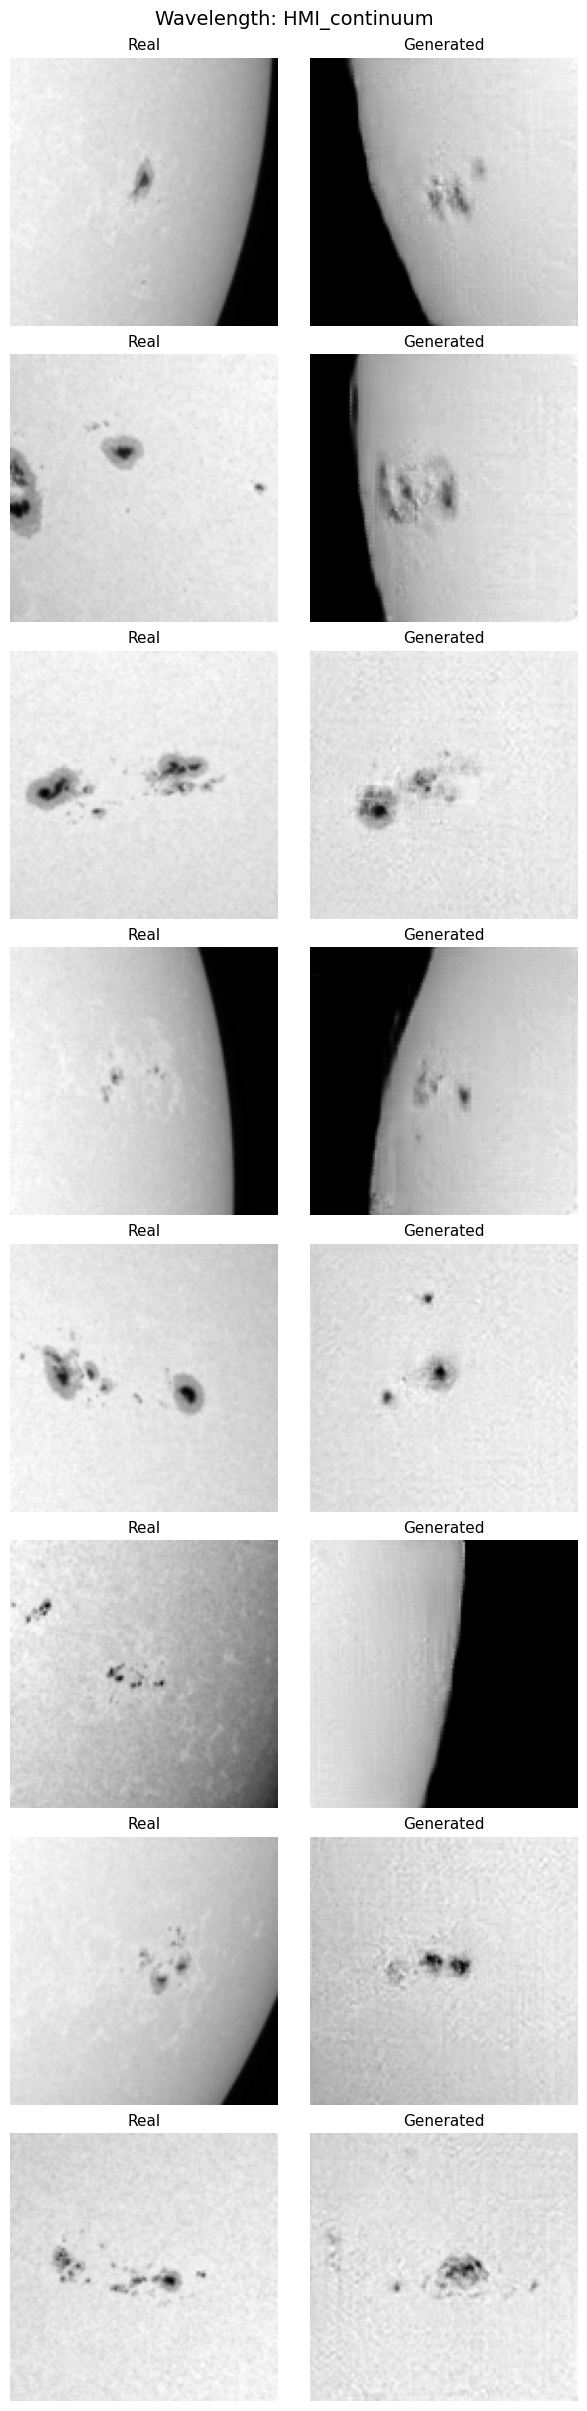

In [58]:
real_path = "severe cases/HMI_continuum"   # or your specific wavelength folder
plot_real_vs_fake_from_path(
    real_dir=real_path,
    n_rows=8,
    use_ema=True,
    vis_mode="stretch",
    save_path="real_vs_fake_HMI_continuum.png"
)


In [52]:
!pip install tqdm
!pip install scikit-image

In [53]:
import torch, re
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- ARCH: must match training ----
def weights_init_dcgan(m):
    name = m.__class__.__name__
    if "Conv" in name and hasattr(m, "weight"):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None: nn.init.zeros_(m.bias)
    elif "BatchNorm" in name:
        if getattr(m, "weight", None) is not None: nn.init.normal_(m.weight, 1.0, 0.02)
        if getattr(m, "bias", None)   is not None: nn.init.zeros_(m.bias)

class ResUpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.skip  = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        out = self.conv1(x); out = self.bn1(out); out = F.relu(out, True)
        out = self.conv2(out); out = self.bn2(out)
        skip = self.skip(x)
        return F.relu(out + skip, True)

class SelfAttention(nn.Module):
    def __init__(self, ch, sn=False):
        super().__init__()
        conv = (lambda *a, **k: SN(nn.Conv2d(*a, **k))) if sn else nn.Conv2d
        self.f = conv(ch, ch//8, 1, bias=False)
        self.g = conv(ch, ch//8, 1, bias=False)
        self.h = conv(ch, ch//2, 1, bias=False)
        self.v = conv(ch//2, ch, 1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        b,c,H,W = x.size()
        f = self.f(x).view(b,-1,H*W)
        g = self.g(x).view(b,-1,H*W)
        beta = torch.softmax(torch.bmm(f.transpose(1,2), g), dim=-1)
        h_ = self.h(x).view(b,-1,H*W)
        o = torch.bmm(h_, beta).view(b,-1,H,W)
        o = self.v(o)
        return self.gamma * o + x

class Generator128_Res(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.fc = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16), nn.ReLU(True),
            nn.Conv2d(ngf*16, ngf*16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf*16), nn.ReLU(True),
        )
        self.b1 = ResUpBlock(ngf*16, ngf*8)   # 4->8
        self.b2 = ResUpBlock(ngf*8,  ngf*4)   # 8->16
        self.b3 = ResUpBlock(ngf*4,  ngf*2)   # 16->32
        self.attn32 = SelfAttention(ngf*2, sn=False)  # comment out if you trained without
        self.b4 = ResUpBlock(ngf*2,  ngf)     # 32->64
        self.to_rgb = nn.Sequential(
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),  # 64->128
            nn.Tanh(),
        )
    def forward(self, z):
        x = self.fc(z)
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.attn32(x)   # comment out if not used in training
        x = self.b4(x)
        return self.to_rgb(x)

# ---- HYPERPARAMS: must match training ----
nc  = 1
nz  = 128
ngf = 160
RUN_DIR = Path("wgangp_128")  # adjust if different
CKPT_DIR = RUN_DIR/"ckpt"

# ---- Load latest G checkpoint ----
ckpts = sorted(CKPT_DIR.glob("epoch_*_G.pt")); assert ckpts, f"No ckpts in {CKPT_DIR}"
last = ckpts[-1]
state = torch.load(last, map_location=device)
print(f"Loaded {last.name}, epoch={state.get('epoch','?')}")

G = Generator128_Res(nz, ngf, nc).to(device)
G.load_state_dict(state["G"])
G.eval()


/tmp/ipykernel_134283/500340195.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(last, map_location=device)


Loaded epoch_0500_G.pt, epoch=500


Generator128_Res(
  (fc): Sequential(
    (0): ConvTranspose2d(128, 2560, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(2560, 2560, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (b1): ResUpBlock(
    (conv1): Conv2d(2560, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(2560, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (b2): ResUpBlock(
    (conv1): Conv2d(1280, 640, kernel_size=(3, 3

In [54]:
# ==== SSIM / PSNR evaluation for GAN images ====
import os, math, csv, random, torch
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from datetime import datetime  # <--- added

# --- helpers ---
def to_display(x, mode="linear", eps=1e-6):
    if mode == "linear":
        y = (x + 1) / 2
    else:  # "stretch"
        B = x.size(0); flat = x.view(B, -1)
        mn = flat.min(dim=1, keepdim=True).values
        mx = flat.max(dim=1, keepdim=True).values
        y = ((flat - mn) / (mx - mn + eps)).view_as(x)
    return y.clamp(0,1)

def pil_load_resize(path, size=(128,128), nc=1):
    img = Image.open(path).convert("RGB" if nc==3 else "L")
    if img.size != size: img = img.resize(size, Image.BICUBIC)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    if nc == 1:
        if arr.ndim == 3:
            arr = arr[...,0]
    return arr

@torch.no_grad()
def generate_batch(G_or_EMA, n, nz, device):
    z = torch.randn(n, nz, 1, 1, device=device)
    x = G_or_EMA(z)
    x = to_display(x, "linear")
    x = x.clamp(0,1).cpu().numpy()
    if x.shape[1] == 1:
        x = x[:,0,:,:]
    else:
        x = np.transpose(x, (0,2,3,1))
    return x

def eval_ssim_psnr(real_dir,
                   N=64,
                   size=(128,128),
                   paired=True,
                   seed=123,
                   cand_pool=128,
                   use_ema=True,
                   csv_out=None,
                   save_examples_dir=None,
                   summary_csv="metrics_summary_HMI_continuum.csv"):  # <--- new optional summary file
    """
    real_dir: path to folder of real images
    N: number of images to evaluate
    paired: True=paired comparison, False=nearest comparison
    """
    rng = random.Random(seed)

    # 1) list real files
    real_files = [f for f in os.listdir(real_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff",".bmp"))]
    assert real_files, f"No images found in {real_dir}"
    real_files.sort()
    if paired and len(real_files) < N:
        raise ValueError(f"paired=True requires at least N={N} real images (found {len(real_files)})")

    # 2) choose generator (EMA if available)
    model = (ema.tgt if (use_ema and 'ema' in globals()) else G).eval()
    dev = next(model.parameters()).device

    # 3) generate N fake images
    fake_np = generate_batch(model, N, nz, dev)

    # 4) load matching real(s)
    h, w = size
    multichannel = (nc==3)

    def ssim_fn(a, b):
        return ssim_metric(a, b, data_range=1.0, channel_axis=-1 if multichannel else None)
    def psnr_fn(a, b):
        return psnr_metric(a, b, data_range=1.0)

    ssim_scores, psnr_scores = [], []
    rows = []

    if save_examples_dir:
        save_examples_dir = Path(save_examples_dir)
        save_examples_dir.mkdir(parents=True, exist_ok=True)

    for i in tqdm(range(N), desc=f"Evaluating ({'paired' if paired else 'nearest'})"):
        if paired:
            r_path = Path(real_dir) / real_files[i]
            real = pil_load_resize(r_path, size=size, nc=nc)
            best_ssim = ssim_fn(fake_np[i], real)
            best_psnr = psnr_fn(fake_np[i], real)
            chosen_file = str(r_path.name)
        else:
            cand_files = rng.sample(real_files, min(cand_pool, len(real_files)))
            best_ssim, best_psnr, chosen_file = -1.0, -1.0, None
            for cf in cand_files:
                real = pil_load_resize(Path(real_dir)/cf, size=size, nc=nc)
                s = ssim_fn(fake_np[i], real)
                if s > best_ssim:
                    best_ssim = s
                    best_psnr = psnr_fn(fake_np[i], real)
                    chosen_file = cf

        ssim_scores.append(best_ssim)
        psnr_scores.append(best_psnr)
        rows.append({"index": i, "real_file": chosen_file, "SSIM": best_ssim, "PSNR": best_psnr})

        if save_examples_dir and i < 16:
            if nc == 1:
                fake_t = torch.from_numpy(fake_np[i]).unsqueeze(0)
                real_t = torch.from_numpy(pil_load_resize(Path(real_dir)/chosen_file, size=size, nc=nc)).unsqueeze(0)
            else:
                fake_t = torch.from_numpy(fake_np[i]).permute(2,0,1)
                real_t = torch.from_numpy(pil_load_resize(Path(real_dir)/chosen_file, size=size, nc=nc)).permute(2,0,1)
            save_image(fake_t, save_examples_dir/f"fake_{i:03d}.png")
            save_image(real_t, save_examples_dir/f"real_{i:03d}.png")

    mean_ssim = float(np.mean(ssim_scores))
    mean_psnr = float(np.mean(psnr_scores))
    print(f"SSIM (mean over {N}): {mean_ssim:.4f}")
    print(f"PSNR (mean over {N}): {mean_psnr:.2f} dB")

    # --- save per-image metrics ---
    if csv_out:
        with open(csv_out, "w", newline="") as f:
            wcsv = csv.DictWriter(f, fieldnames=["index","real_file","SSIM","PSNR"])
            wcsv.writeheader()
            for r in rows:
                wcsv.writerow(r)
        print(f"Saved detailed metrics to: {csv_out}")

    # --- append summary row ---
    if summary_csv:
        summary_fields = ["timestamp", "mode", "N", "mean_SSIM", "mean_PSNR", "csv_details"]
        file_exists = os.path.exists(summary_csv)
        with open(summary_csv, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=summary_fields)
            if not file_exists:
                writer.writeheader()
            writer.writerow({
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "mode": "paired" if paired else "nearest",
                "N": N,
                "mean_SSIM": mean_ssim,
                "mean_PSNR": mean_psnr,
                "csv_details": csv_out
            })
        print(f"Appended summary to: {summary_csv}")

    model.train()
    return mean_ssim, mean_psnr


In [55]:
# by order 

real_dir = "severe cases/HMI_continuum"  # your real images folder
eval_ssim_psnr(
    real_dir=real_dir,
    N=128,                      # number of pairs to evaluate
    size=(128,128),
    paired=True,                # <-- paired mode
    use_ema=True,               # sample from EMA if available
    csv_out="metrics_paired_HMI_continuum.csv",
    save_examples_dir="paired_examples"
)


Evaluating (paired): 100%|██████████| 128/128 [00:00<00:00, 216.19it/s]


SSIM (mean over 128): 0.4783
PSNR (mean over 128): 13.55 dB
Saved detailed metrics to: metrics_paired_HMI_continuum.csv
Appended summary to: metrics_summary_HMI_continuum.csv


(0.47829962553019467, 13.5489975406913)

In [56]:
real_dir = "severe cases/HMI_continuum"
eval_ssim_psnr(
    real_dir=real_dir,
    N=128,
    size=(128,128),
    paired=False,               # <-- unpaired mode (proxy)
    cand_pool=128,              # candidates per fake (increase for better match, slower)
    use_ema=True,
    csv_out="metrics_nearest_HMI_continuum.csv",
    save_examples_dir="nearest_examples"
)


Evaluating (nearest): 100%|██████████| 128/128 [00:40<00:00,  3.13it/s]

SSIM (mean over 128): 0.6830
PSNR (mean over 128): 22.10 dB
Saved detailed metrics to: metrics_nearest_HMI_continuum.csv
Appended summary to: metrics_summary_HMI_continuum.csv


(0.6830394545518902, 22.098960055137134)